In [2]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import default_collate
from typing import Mapping

In [51]:
from miniai.img_plotting import *
from miniai.training import *
import torch, torch.nn as nn, torch.nn.functional as F
from torch import tensor, optim
from torch.utils.data import DataLoader

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl

mpl.rcParams['image.cmap'] = 'Greys'
torch.set_printoptions(precision=2, linewidth=100)

In [4]:
data = pd.read_csv('data/fashion_mnist/train.csv')

In [5]:
X_train = tensor(data.iloc[:50000, 1:].values)
y_train = tensor(data.iloc[:50000, 0].values)
X_valid = tensor(data.iloc[50000:, 1:].values)
y_valid = tensor(data.iloc[50000:, 0].values)

<Axes: >

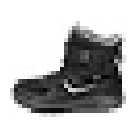

In [6]:
show_image(X_train[0], shape=[28, 28])

In [7]:
img = X_train[0].view(28, 28) / 255.

In [8]:
kernel = tensor([
    [1, 1, 1, 1],
    [-1, 1, 1, 1],
    [-1, -1, 1, 1],
    [-1, -1, -1, 1]
])

<Axes: >

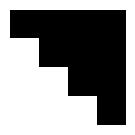

In [9]:
show_image(kernel)

In [10]:
df = pd.DataFrame(img)
df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.29,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.14,0.53,0.50,0.24,0.21,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.01
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.40,0.80,0.69,0.53,0.56,0.48,0.09,0.00,0.00,0.00,0.00,0.05,0.04,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.61,0.93,0.81,0.70,0.42,0.61,0.63,0.43,0.25,0.09,0.30,0.51,0.28,0.06
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.81,0.87,0.85,0.85,0.85,0.64,0.50,0.47,0.48,0.57,0.55,0.35,0.67,0.26
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.78,0.91,0.91,0.91,0.90,0.87,0.87,0.84,0.84,0.64,0.50,0.48,0.77,0.90,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.88,0.85,0.87,0.89,0.92,0.89,0.88,0.87,0.88,0.87,0.87,0.96,0.68,0.00


In [11]:
def apply_kernel(kenel, row, col):
    ks = kernel.shape[0]
    return (img[row-(ks-1)//2:row+ks//2+1, col-(ks-1)//2:col+ks//2+1]*kernel).sum()

In [12]:
apply_kernel(kernel, 25, 20)

tensor(2.76)

In [13]:
conv_1 = tensor([[apply_kernel(kernel, i, j) for j in range(1, 26)] for i in range(1, 26)])

<Axes: >

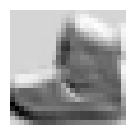

In [14]:
show_image(conv_1)

<br>

In [15]:
kernel = tensor([[1, 1, 1], [0.6, 0.6, 0.6], [-1, -1, -1]])

In [16]:
unf = F.unfold(img[None, None, :, :], kernel_size=(3, 3))[0]

In [17]:
unf.shape

torch.Size([9, 676])

In [18]:
conv = (kernel.view(-1)@unf).view(26, 26)

<Axes: >

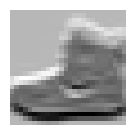

In [19]:
show_image(conv)

In [20]:
conv = F.conv2d(img[None, None], kernel[None, None])

<Axes: >

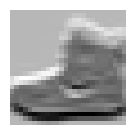

In [21]:
show_image(conv.view(26, 26))

<br><br>

In [22]:
k1 = tensor([[0, -1, 1],
             [-1, 1, 0],
             [1, 0, 0]]).float()
k2 = tensor([[1, -1, 0],
             [0, 1, -1],
             [0, 0, 1]]).float()
k3 = torch.randn(3, 3)

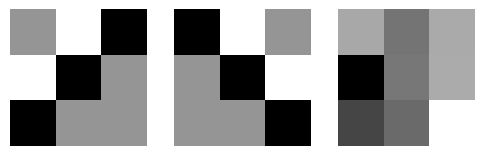

In [23]:
show_images([k1, k2, k3], nrows=1, ncols=3)

In [24]:
kernels = torch.stack([k1, k2, k3])[:, None]

In [25]:
kernels.shape

torch.Size([3, 1, 3, 3])

In [26]:
X_b = X_train[:10].view(-1, 1, 28, 28) / 255.; X_b.shape

torch.Size([10, 1, 28, 28])

In [27]:
convs = F.conv2d(X_b, kernels); convs.shape

torch.Size([10, 3, 26, 26])

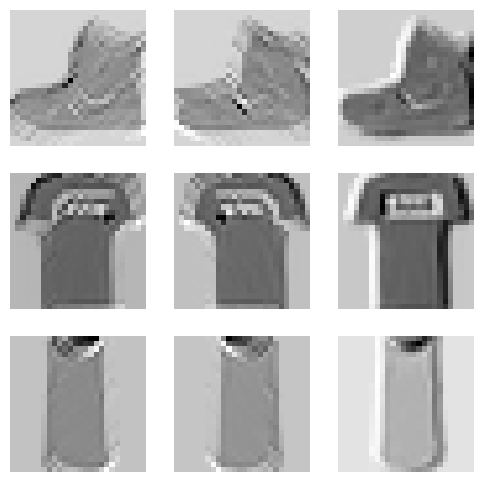

In [28]:
show_images(images=[convs[i//3, i%3] for i in range(9)], shape=[26, 26], nrows=3, ncols=3)

<br><br>**Model**

In [70]:
default_collate??

In [3]:
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def collate_device(b, device=def_device): return to_device(default_collate(b), device)

In [81]:
dset_train = Dataset((X_train/255. ).view(-1, 1, 28, 28), y_train)
dset_valid = Dataset((X_valid/255. ).view(-1, 1, 28, 28), y_valid)

In [82]:
dl_train = DataLoader(dset_train, batch_size=64, shuffle=True, collate_fn=collate_device)
dl_valid = DataLoader(dset_valid, batch_size=len(dset_valid), shuffle=False, collate_fn=collate_device)

In [4]:
def conv(in_f, out_f, ks=3, act=None, stride=2):
    res = nn.Conv2d(in_f, out_f, ks, stride, padding=ks//2)
    if act is None: return res
    return nn.Sequential(res, act)

In [99]:
model = nn.Sequential(
    conv(1, 32, act=nn.ReLU()), #14×14
    conv(32, 64, act=nn.ReLU()), #7×7
    conv(64, 128, act=nn.ReLU()), #4×4
    conv(128, 256, act=nn.ReLU()), #2×2
    conv(256, 10, act=None), #1×1
    nn.Flatten()
)

In [100]:
lr = 1e-3
opt = optim.Adam(model.parameters(), lr)
train(1, lr, opt, model, F.cross_entropy, dl_train, dl_valid)

0.5298	0.3898	0.8556
